# Orbit and stream simulation

# 1. Orbit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from astropy import units
from astropy.io import ascii
import corner
from plot_functions import *

from galpy.orbit import Orbit
from galpy.util.conversion import get_physical
from galpy.potential import MWPotential2014, ChandrasekharDynamicalFrictionForce, HernquistPotential, \
                            MovingObjectPotential, evaluateRforces, evaluatephitorques, evaluatezforces, \
                            NonInertialFrameForce
from galpy.df import streamspraydf
from galpy.potential.mwpotentials import McMillan17

A new version of galpy (1.9.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
# params imported from plot_functions
params['xtick.labelsize'] = 12
params['ytick.labelsize'] = 12
params['axes.labelsize'] = 12
params['axes.titlesize'] = 14
plt.rcParams.update(params)

### Data from other sources

In [3]:
styx_trace = ascii.read('styx.trace')

# from Dr. Erkal
data_wlmc = ascii.read('dwarf_stream_bootes_3_wLMC.txt')
data_wolmc = ascii.read('dwarf_stream_bootes_3_woLMC.txt')

## Functions
(just large blocks of code that need to be used many times)

Note a few physical values from galpy's default configuration:
- Solar radius R = 8 kpc
- Circular velocity V = 220 km/s
- Solar motion [Schoenrich 2010](http://adsabs.harvard.edu/abs/2010MNRAS.403.1829S)

In [4]:
SOLAR_MOTION = [-11.1, 12.24, 7.25]

In [5]:
def get_total_potential(forward=False):
    """Return a potential that combines the MWPotential2014 model,
    the LMC's potential, and a non-inertial frame force (the MW's 
    reflex motion in response to the LMC's infall).
    
    The potential created is only valid for 5 Gyr in forward/backward 
    modelling. If <forward> is True, the potential is created for
    forward integration.
    """
    mass_lmc = 1.38e11  # M_sun
    rscale = 16.09  # kpc, scale radius (a), calculated using Eq. 3 from Hernquist 1990
    rhm = rscale * (1 + np.sqrt(2))  # half-mass radius, rhm = a * (1 + sqrt(2))
    
    # Define the LMC orbit object
    orbit_LMC = Orbit.from_name('LMC', solarmotion=SOLAR_MOTION)

    # Define dynamical friction force
    cdf = ChandrasekharDynamicalFrictionForce(GMs=mass_lmc*units.Msun, rhm=rhm*units.kpc, dens=MWPotential2014)

    # Integrate the LMC orbit with the dynamical friction
    ts = np.linspace(0, 5, 1001)*units.Gyr
    if forward:
        orbit_LMC.integrate(ts, MWPotential2014 + cdf)
    else:
        orbit_LMC.integrate(-ts, MWPotential2014 + cdf)
        
    # Set it as moving object potential
    lmcpot = HernquistPotential(amp=2*mass_lmc*units.Msun, a=rscale*units.kpc)
    moving_lmcpot = MovingObjectPotential(orbit_LMC, pot=lmcpot)

    # Acceleration at origin
    loc_origin= 1e-4 # Small offset in R to avoid numerical issues
    ax = lambda t : evaluateRforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)
    ay = lambda t : evaluatephitorques(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False) / loc_origin
    az = lambda t : evaluatezforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)

    # Use interpolation function to speed things up
    if forward:
        t_intunits= orbit_LMC.time(use_physical=False)
    else:
        t_intunits= orbit_LMC.time(use_physical=False)[::-1]

    ax4int = np.array([ax(t) for t in t_intunits])
    ax_int = lambda t : np.interp(t, t_intunits, ax4int)
    ay4int = np.array([ay(t) for t in t_intunits])
    ay_int = lambda t : np.interp(t, t_intunits, ay4int)
    az4int = np.array([az(t) for t in t_intunits])
    az_int = lambda t : np.interp(t, t_intunits, az4int)

    nip = NonInertialFrameForce(a0=[ax_int, ay_int, az_int])

    return MWPotential2014 + nip + moving_lmcpot

In [9]:
def ax_plot_realizations(ax, component_for_x, component_for_y):
    """Take every 10th element in <component_for_x> and <component_for_y>, which are
    attributes of an Orbit instance that contains many orbits, and plot them onto <ax>.
    
    This is for convenient plotting of the many realizations of orbits made to account
    for the 6D parameters uncertainties.
    """
    for (x, y) in zip(component_for_x[::10], component_for_y[::10]):
        ax.plot(x, y, c='deepskyblue', alpha=0.1, zorder=1)


def generate_orbit_model(params_6D, errors, max_time, potential_forward, potential_backward,
                         solar_motion=SOLAR_MOTION, 
                         num_of_realizations=1000, plots_only=False, save_plots=False, title_text='', save_text=''):
    """The complete function for integrating and displaying the orbit.
    
    Note: This only works correctly for potentials made from MWPotential2014.
    This function does not work for any other potential, like McMillan17
    because each of them are a little different with their parameters,
    it would not be any more efficient to write a function.
    
    Parameters
    ----------
    params_6D:
        The 6D phase-space parameters of the dwarf galaxy. 
        In this order, [ra, dec, distance, pmra, pmdec, velocity].
    errors:
        The uncertainties for the 6D parameters. 
        Enter 0 for the parameters that do not have uncertainties.
    max_time:
        The time (in Gyr) for the integration to run until. 
        This is used to create a numpy array for the timescale.
    potential_forward:
        Either MWPotential2014 or a combined potential with LMC.
    potential_backward:
        This input is the same as above if there's no LMC included,
        but for LMC we must consider the potential for forward and 
        backward separately. This is because the LMC is a moving potential,
        so backward potential requires the rewind orbit of LMC.
    solar_motion:
        The same solar motion parameter as in galpy.
        This is an option to change the total solar velocity V_phi, 
        which is an empirical value important for coordinate conversions.
    num_of_realizations:
        The number of orbits to generate given the uncertainties on
        the 6D parameters.
    plots_only:
        Controls what to return.
    save_plots:
        Controls saving the plots.
    
    Return
    ------
    If <plots_only> is False (default):
        Generate the plots and then
        Return the galpy Orbit objects that represent the model result.
        This includes the forward orbit, backward orbit, their 
        different realizations, and the timescale array.
    If <plots_only> is True:
        Only output the plots of the orbit integration.
    """
    # Prepare the parameters for the realizations
    params_6D_many = np.random.normal(loc=params_6D, scale=errors, 
                                      size=(num_of_realizations, 6))
    # Make timescale
    ts = np.linspace(0, max_time, 1001) * units.Gyr

    # Create orbits
    orbit_forward = Orbit(params_6D, solarmotion=solar_motion, radec=True)
    orbit_backward = Orbit(params_6D, solarmotion=solar_motion, radec=True)
    orbit_forward_many = Orbit(params_6D_many, solarmotion=solar_motion, radec=True)
    orbit_backward_many = Orbit(params_6D_many, solarmotion=solar_motion, radec=True)
    
    # Integrate
    orbit_forward.integrate(ts, potential_forward)
    orbit_backward.integrate(-ts, potential_backward)
    orbit_forward_many.integrate(ts, potential_forward)
    orbit_backward_many.integrate(-ts, potential_backward)
    
    # Plot in this order: XY-plane, XZ-plane, YZ-plane, and R vs. t
    fig, axs = plt.subplots(1, 4, figsize=(12.4, 3))

    for ax, plane in zip(axs, ['XY', 'XZ', 'YZ', 'RT']):
        skip_forward = False

        # Determine what we are plotting
        if plane == 'XY':
            xf, yf = orbit_forward.x(ts), orbit_forward.y(ts)                        # "forward"
            xb, yb = orbit_backward.x(-ts), orbit_backward.y(-ts)                    # "backward" 
            xf_err, yf_err = orbit_forward_many.x(ts), orbit_forward_many.y(ts)      # their "errors"
            xb_err, yb_err = orbit_backward_many.x(-ts), orbit_backward_many.y(-ts)
        elif plane == 'XZ':
            xf, yf = orbit_forward.x(ts), orbit_forward.z(ts)
            xb, yb = orbit_backward.x(-ts), orbit_backward.z(-ts)
            xf_err, yf_err = orbit_forward_many.x(ts), orbit_forward_many.z(ts)
            xb_err, yb_err = orbit_backward_many.x(-ts), orbit_backward_many.z(-ts)
        elif plane == 'YZ':
            xf, yf = orbit_forward.y(ts), orbit_forward.z(ts)
            xb, yb = orbit_backward.y(-ts), orbit_backward.z(-ts)
            xf_err, yf_err = orbit_forward_many.y(ts), orbit_forward_many.z(ts)
            xb_err, yb_err = orbit_backward_many.y(-ts), orbit_backward_many.z(-ts)
        else:
            # No need the forward part for R vs. t
            skip_forward = True
            xb, yb = orbit_backward.time(-ts), orbit_backward.r(-ts)
            xb_err = np.tile(orbit_backward_many.time(-ts), (num_of_realizations, 1))
            yb_err = orbit_backward_many.r(-ts)

        # forward
        if not skip_forward:
            ax.plot(xf, yf, c='k', ls='-', zorder=2)
            ax_plot_realizations(ax, xf_err, yf_err)
        # backward
        ax.plot(xb, yb, c='k', ls='--', zorder=2)
        ax_plot_realizations(ax, xb_err, yb_err)

        ax.plot(xb[0], yb[0], 'ok', zorder=2)
        if plane != 'RT':
            ax.set_xlabel(plane[0] + ' [kpc]')
            ax.set_ylabel(plane[1] + ' [kpc]')
            ax.set_xlim(-180, 180)
            ax.set_ylim(-180, 180)
        else:
            ax.set_xlabel('t [Gyr]')
            ax.set_ylabel('R [kpc]')
            ax.set_ylim(0, 230)

        ax.set_aspect('auto')

    plt.tight_layout()
    plt.suptitle(title_text, y=1.05)
    if save_plots:
        fig.savefig(f'{save_text}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    if not plots_only:
        return orbit_forward, orbit_backward, orbit_forward_many, orbit_backward_many, ts
    else:
        return

### Input setup

In [10]:
# 6D parameters
RA_BOO3 = 209.3     # deg  (from Grillmair 2009)
DEC_BOO3 = 26.8     # deg
DIST_BOO3 = 46.5    # kpc  (from Carlin 2018)
PMRA_BOO3 = -1.16   # mas yr^-1  (from Part 1 of this work)
PMDEC_BOO3 = -0.88  # mas yr^-1
VEL_BOO3 = 191.31   # km s^-1

# Uncertainties (no value for positions)
U_DIST_BOO3 = 2.0   
U_PMRA_BOO3 = 0.02  
U_PMDEC_BOO3 = 0.01 
U_VEL_BOO3 = 0.75  

boo3_6D = [RA_BOO3, DEC_BOO3, DIST_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3]
boo3_6D_unc = [0, 0, U_DIST_BOO3, U_PMRA_BOO3, U_PMDEC_BOO3, U_VEL_BOO3]

## MWPotential2014

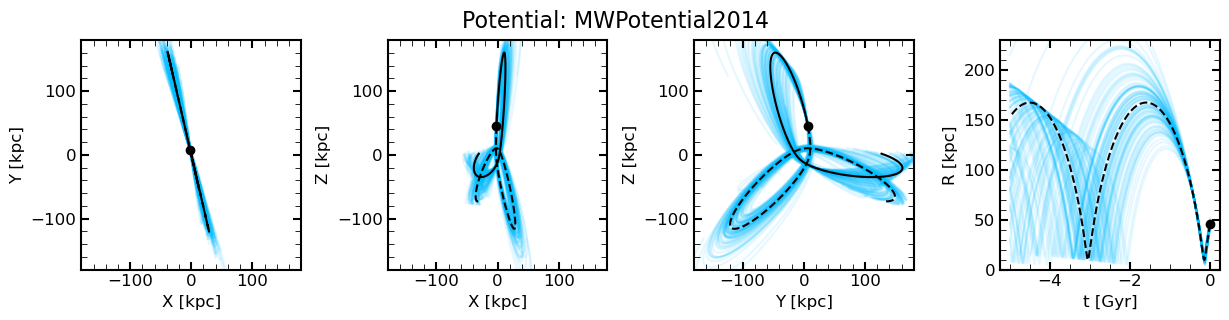

In [11]:
result = generate_orbit_model(boo3_6D, boo3_6D_unc, 5, MWPotential2014, MWPotential2014, 
                              save_plots=True, 
                              title_text='Potential: MWPotential2014', 
                              save_text='orbit_MWPotential2014')

orbit_forward, orbit_backward, orbit_forward_many, orbit_backward_many, ts = result

## MWPotential2014 + LMC + reflex motion (barycentric acceleration)

In [12]:
total_potential_backward = get_total_potential()
total_potential_forward = get_total_potential(forward=True)

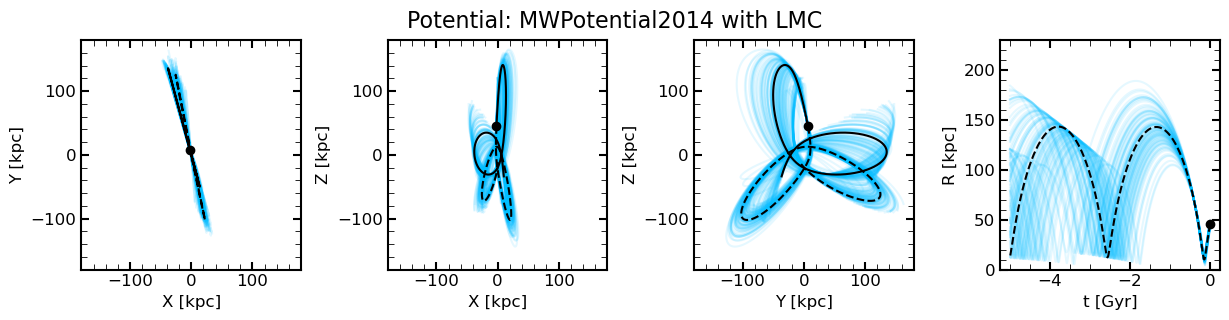

In [13]:
result2 = generate_orbit_model(boo3_6D, boo3_6D_unc, 5, 
                               total_potential_forward, total_potential_backward, 
                               save_plots=True, 
                               title_text='Potential: MWPotential2014 with LMC', 
                               save_text='orbit_MWPotential2014_LMC')

orbit_forward2, orbit_backward2, orbit_forward_many2, orbit_backward_many2, ts2 = result2

## Orbital properties

For getting the most recent pericenter and apocenter, we can't use the built-in rperi() and rap() because they take the global extremum values. We will use a scipy trick to get the indices of all pericenters and apocenters, and take the first index.

The commented lines will show the difference between using the scipy trick and using rperi() and rap(). The latter result *may not be* the most recent pericenter and apocenter passages.

In [25]:
def generate_peri_apo_distributions(orbits, ts, get_peri_time=False, fig_title='', save_title=''):
    """Note: there's some added code that calculates the time of pericenter occurrence.
    For this particular setup I know the time array is in Gyr (astropy Quantity), but it will
    be wrong if the input timescale <ts> is in other units, watch out for that
    """
    all_peri = []
    all_apo = []
    time_of_peri = []
    time_of_apo = []
    for orbit in orbits:
        peri_index = argrelextrema(orbit.r(-ts), np.less)[0][0]
        apo_index = argrelextrema(orbit.r(-ts), np.greater)[0][0]
        all_peri.append(orbit.r(-ts)[peri_index])
        all_apo.append(orbit.r(-ts)[apo_index])
        
        # This line will give wrong results if time is not in Gyr!
        time_of_peri.append(-ts[peri_index].value)

    figure = corner.corner(np.vstack((all_peri, all_apo, orbits.e())).T,
                       labels=['$r_\mathrm{peri}$', '$r_\mathrm{apo}$', '$e$'],
                       quantiles=[0.16, 0.50, 0.84],
                       show_titles=True,
                       #plot_datapoints=False,
                       title_kwargs={"fontsize": 13},
                       label_kwargs = dict(fontsize=15),
                       #range=[[np.array(all_peri).min(), np.array(all_peri).max()], [np.array(all_apo).min(), np.array(all_apo).max()], [0.87, orbits.e().max()]],
                       ls='--', c='gray')
    figure.set_size_inches(6, 6)
    
    axes = figure.get_axes()
    axes[0].text(3, 0.5, fig_title, fontsize=14, ha='right', va='top', transform=axes[0].transAxes)
    figure.savefig(save_title, dpi=300, bbox_inches='tight')
    plt.show()
    
    if get_peri_time:
        return time_of_peri

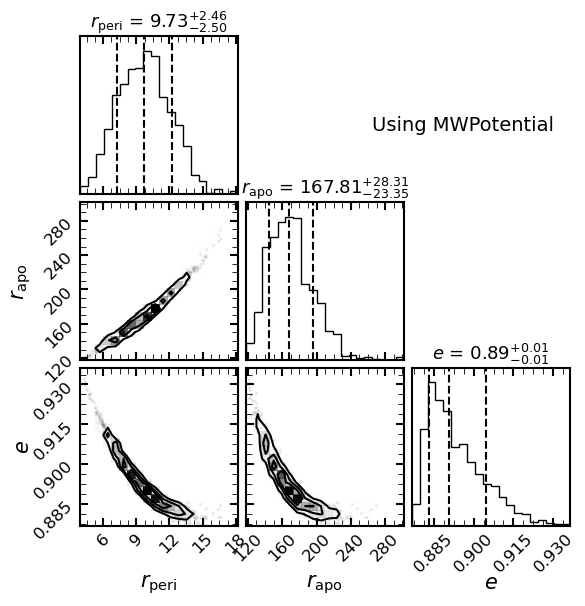

In [28]:
time_of_peri = generate_peri_apo_distributions(orbit_backward_many, ts, 
                                               get_peri_time=True,
                                               fig_title='Using MWPotential', 
                                               save_title='orbit_params_nolmc.png')

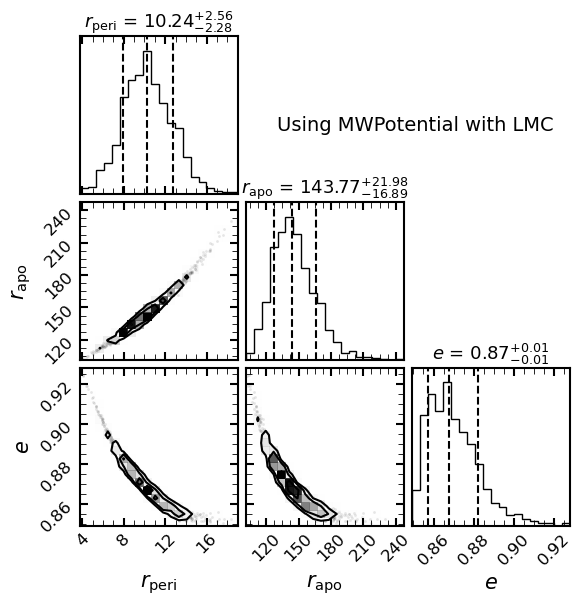

In [29]:
time_of_peri2 = generate_peri_apo_distributions(orbit_backward_many2, ts2,
                                                get_peri_time=True,
                                                fig_title='Using MWPotential with LMC', 
                                                save_title='orbit_params_wlmc.png')

In [31]:
import uncertainties

def get_median_with_errors(data):
    median = np.percentile(data, 50)
    error1 = np.percentile(data, 50) - np.percentile(data, 16)
    error2 = np.percentile(data, 84) - np.percentile(data, 50)
    error = (error1 + error2) / 2
    
    return uncertainties.ufloat(median, error)

In [32]:
time_of_peri = np.array(time_of_peri)
time_of_peri2 = np.array(time_of_peri2)

t_peri = get_median_with_errors(time_of_peri)    # Gyr
t_peri2 = get_median_with_errors(time_of_peri2)  # Gyr

In [37]:
vlos_disp = uncertainties.ufloat(1.88, 0.79)  # km/s

Time is in `Gyr`, velocity dispersion is in `km/s`. Both have uncertainties. Let's do some manual unit conversions and multiply them.

In [42]:
# flip the sign for the negative time
# convert Gyr to seconds
# convert km to parsec

dist = -t_peri * vlos_disp * 3.1536e16 / 3.086e13
dist2 = -t_peri2 * vlos_disp * 3.1536e16 / 3.086e13

In [49]:
print(f"Without LMC\nThe radius of the bound region of the system: {dist:.2f} [parsec]")
print(f"With LMC\nThe radius of the bound region of the system: {dist2:.2f} [parsec]")

Without LMC
The radius of the bound region of the system: 268.97+/-113.94 [parsec]
With LMC
The radius of the bound region of the system: 278.57+/-117.94 [parsec]


# 2. Stream

We create many variations of stream models. We call the **Default** setting as this:

| Parameter Name         | Quantity                        |
|------------------------|---------------------------------|
| Progenitor mass        | $10^7~M_\odot$                  |
| Galactic Potential     | MWPotential2014 with LMC |
| LMC mass               | $1.38 \times 10^{11}~\mathrm{M}_\odot$ |
| LMC half-mass radius   | 38.84 kpc                       |
| Time of Disruption     | 3 Gyr                           |
| Total velocity $V_\phi$ | $232.24~\mathrm{km~s}^{-1}$     |

And `solarmotion = [-11.1, 12.24, 7.25]`.

Then, we create these versions of the stream. The variable names use the following numbers accordingly.
1. Default
2. Default with LMC mass x2
3. Default with LMC rhm x2
4. Default with MW halo mass x2
5. Default with vphi = 245 (v_sun changed to 25)
6. Default without LMC
7. Default without LMC and with vphi = 245
8. Default BUT using McMillan17 (this also has vphi = 245)

In [7]:
def _get_potential_for_stream(base_potential, lmc_mass_factor=1, rhm_factor=1, halo_mass_factor=1, solar_motion=SOLAR_MOTION):
    """Private function for generate_stream_model().
    
    NOTE: This function assumes the <base_potential> is either MWPotential2014 or McMillan17,
    because they are the only relevant potentials in this work. Using any other potential 
    may cause fatal error.
    
    Same as get_total_potential(), with three additional options:
    1. Increase the LMC mass by lmc_mass_factor
    2. Increase LMC rhm (half mass radius) by rhm_factor
    3. Increase MWPotential2014 mass by halo_mass_factor
    
    Default values are 1, which means there are no increases.
    """
    ts = np.linspace(0, 5, 1001) * units.Gyr
    
    rscale = 16.09 * units.kpc
    lmc_rhm = rscale * (1 + np.sqrt(2))
    lmc_mass = 1.38e11*units.Msun
    mw_mass = base_potential.copy()
    
    lmc_mass *= lmc_mass_factor
    lmc_rhm *= rhm_factor
    if halo_mass_factor != 1:
        mw_mass[2] *= halo_mass_factor

    orbit_LMC = Orbit.from_name('LMC', solarmotion=solar_motion, **get_physical(base_potential))
    
    # Should be either MWPotential2014 or McMillan17
    if base_potential == MWPotential2014 or base_potential[0:2] == MWPotential2014[0:2]: # This is when we modify the mass
        cdf = ChandrasekharDynamicalFrictionForce(GMs=lmc_mass, rhm=lmc_rhm, dens=mw_mass, **get_physical(base_potential))
    else:
        cdf = ChandrasekharDynamicalFrictionForce(GMs=lmc_mass, rhm=lmc_rhm, dens=mw_mass[1], **get_physical(base_potential))

    # For stream we are ONLY interested in backward
    orbit_LMC.integrate(-ts, mw_mass + cdf)
        
    lmcpot = HernquistPotential(amp=2*lmc_mass, a=rscale, **get_physical(base_potential))
    moving_lmcpot = MovingObjectPotential(orbit_LMC, pot=lmcpot, **get_physical(base_potential))

    # Acceleration at origin
    loc_origin= 1e-4 # Small offset in R to avoid numerical issues
    ax = lambda t : evaluateRforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)
    ay = lambda t : evaluatephitorques(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False) / loc_origin
    az = lambda t : evaluatezforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)

    # Use interpolation function to speed things up (again, ONLY backward)
    t_intunits= orbit_LMC.time(use_physical=False)[::-1]

    ax4int = np.array([ax(t) for t in t_intunits])
    ax_int = lambda t : np.interp(t, t_intunits, ax4int)
    ay4int = np.array([ay(t) for t in t_intunits])
    ay_int = lambda t : np.interp(t, t_intunits, ay4int)
    az4int = np.array([az(t) for t in t_intunits])
    az_int = lambda t : np.interp(t, t_intunits, az4int)

    nip = NonInertialFrameForce(a0=[ax_int, ay_int, az_int])

    return mw_mass + nip + moving_lmcpot


def generate_stream_model(base_potential, progenitor_mass, tdisrupt, use_LMC=False,
                          lmc_mass_factor=1, rhm_factor=1, halo_mass_factor=1, solar_motion=SOLAR_MOTION):
    """Note: <progenitor_mass> and <tdisrupt> will be assigned 
    astropy units in the function.
    """
    orbit_boo3 = Orbit(boo3_6D, radec=True, solarmotion=solar_motion)
    
    if use_LMC:
        potential = _get_potential_for_stream(base_potential, lmc_mass_factor, rhm_factor, halo_mass_factor, solar_motion)

        # Leading arm
        spdf = streamspraydf(progenitor_mass = progenitor_mass * units.M_sun,
                             progenitor = orbit_boo3,
                             pot = potential,
                             tdisrupt = tdisrupt * units.Gyr,
                             rtpot = base_potential)

        # Trailing arm
        spdft = streamspraydf(progenitor_mass = progenitor_mass * units.M_sun,
                              progenitor = orbit_boo3,
                              pot = potential,
                              tdisrupt = tdisrupt * units.Gyr,
                              rtpot = base_potential,
                              leading = False)
    else:
        spdf = streamspraydf(progenitor_mass = progenitor_mass * units.M_sun,
                             progenitor = orbit_boo3,
                             pot = base_potential,
                             tdisrupt = tdisrupt * units.Gyr)
        spdft = streamspraydf(progenitor_mass = progenitor_mass * units.M_sun,
                              progenitor = orbit_boo3,
                              pot = base_potential,
                              tdisrupt = tdisrupt * units.Gyr,
                              leading = False)
        
    orbit_leading = spdf.sample(n=200, integrate=True)
    orbit_trailing = spdft.sample(n=200, integrate=True)
    
    return orbit_leading, orbit_trailing

## Generating

In [24]:
import warnings
from galpy.util import galpyWarning
warnings.filterwarnings('ignore', category=galpyWarning)

In [29]:
print("Running simulations...")
print("Progress: 0/8", end='\r')

# ----------------------------------- 1. Default --------------------------------- #
orbit_leading1, orbit_trailing1 = generate_stream_model(base_potential=MWPotential2014,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=True)
print("Progress: 1/8", end='\r')

# -------------------------- 2. Default with LMC mass x2 ------------------------- #
orbit_leading2, orbit_trailing2 = generate_stream_model(base_potential=MWPotential2014,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=True,
                                                        lmc_mass_factor=2)
print("Progress: 2/8", end='\r')

# ----------------------------- 3. Default with LMC rhm x2 ----------------------- #
orbit_leading3, orbit_trailing3 = generate_stream_model(base_potential=MWPotential2014,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=True,
                                                        rhm_factor=2)
print("Progress: 3/8", end='\r')

# ----------------------- 4. Default with MW halo mass x2 ------------------------ #
MWpot14x2 = MWPotential2014.copy()
MWpot14x2[2] *= 2

orbit_leading4, orbit_trailing4 = generate_stream_model(base_potential=MWpot14x2,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=True,
                                                        halo_mass_factor=2)
print("Progress: 4/8", end='\r')

# --------------- 5. Default with vphi = 245 (v_sun changed to 25) --------------- #
orbit_leading5, orbit_trailing5 = generate_stream_model(base_potential=MWPotential2014,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=True,
                                                        solar_motion=[-11.1, 25., 7.25])
print("Progress: 5/8", end='\r')

# ---------------------------- 6. Default without LMC ---------------------------- #
orbit_leading6, orbit_trailing6 = generate_stream_model(base_potential=MWPotential2014,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=False)
print("Progress: 6/8", end='\r')

# ----------------- 7. Default without LMC and with vphi = 245 ------------------- #
orbit_leading7, orbit_trailing7 = generate_stream_model(base_potential=MWPotential2014,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=False,
                                                        solar_motion=[-11.1, 25., 7.25])
print("Progress: 7/8", end='\r')

# ---------- 8. Default BUT using McMillan17 (this also has vphi = 245) ---------- #
orbit_leading8, orbit_trailing8 = generate_stream_model(base_potential=McMillan17,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=True)
print("Progress: 8/8")
print("Complete!")

Running simulations...
Progress: 8/8
Complete!


In [32]:
import pickle

In [34]:
orbit_settings = ["fiducial", "LMC_massX2", "LMC_radiusX2", "MW_massX2", 
                  "Vphi_245", "nolmc", "nolmc_Vphi_245", "McMillan17"]

In [33]:
# orbit_results = [[orbit_leading1, orbit_trailing1],
#                  [orbit_leading2, orbit_trailing2],
#                  [orbit_leading3, orbit_trailing3],
#                  [orbit_leading4, orbit_trailing4],
#                  [orbit_leading5, orbit_trailing5],
#                  [orbit_leading6, orbit_trailing6],
#                  [orbit_leading7, orbit_trailing7],
#                  [orbit_leading8, orbit_trailing8]]

# for i in range(len(orbit_results)):
#     fileObj = open(f'orbit_lead_{orbit_settings[i]}.obj', 'wb')
#     pickle.dump(orbit_results[i][0], fileObj)
#     fileObj.close()
#     # Saving trailing part
#     fileObj = open(f'orbit_trail_{orbit_settings[i]}.obj', 'wb')
#     pickle.dump(orbit_results[i][1], fileObj)
#     fileObj.close()

In [36]:
orbit_results = [[] for _ in range(8)]

for i in range(len(orbit_settings)):
    with open(f'orbit_lead_{orbit_settings[i]}.obj', 'rb') as fileObj:
        orbit_results[i].append(pickle.load(fileObj))

    with open(f'orbit_trail_{orbit_settings[i]}.obj', 'rb') as fileObj:
        orbit_results[i].append(pickle.load(fileObj))

In [167]:
def plot_five_params(ax, orbit_lead, orbit_trail, **kwargs):
    """Specifically for plotting the stream parameters.
    <ax> should contain 5 axes.
    Just making code shorter.
    """
    ax[0].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), np.append(orbit_lead.dec(), orbit_trail.dec()), **kwargs)
    ax[1].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), np.append(orbit_lead.pmra(), orbit_trail.pmra()), **kwargs)
    ax[2].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), np.append(orbit_lead.pmdec(), orbit_trail.pmdec()), **kwargs)
    ax[3].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), np.append(orbit_lead.vlos(), orbit_trail.vlos()), **kwargs)
    ax[4].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), distance_to_dm(1000 * np.append(orbit_lead.dist(), orbit_trail.dist())), **kwargs)

def plot_five_curves(ax, orbit_curves, **kwargs):
    """Specifically for plotting the stream parameters.
    <ax> should contain 5 axes.
    Just making code shorter.
    """
    ax0_kwargs = kwargs.copy()
    ax0_kwargs.pop('label', None)
    
    ax[0].plot(orbit_curves[0][:,0], orbit_curves[0][:,1], **ax0_kwargs)
    ax[1].plot(orbit_curves[1][:,0], orbit_curves[1][:,1], **kwargs)
    ax[2].plot(orbit_curves[2][:,0], orbit_curves[2][:,1], **kwargs)
    ax[3].plot(orbit_curves[3][:,0], orbit_curves[3][:,1], **kwargs)
    ax[4].plot(orbit_curves[4][:,0], orbit_curves[4][:,1], **kwargs)

In [42]:
from analysis_functions_v2 import *

In [ ]:
_names = ["Fiducial", "LMC mass x2", "LMC rhm x2", "MW mass x2", 
          "Vphi = 245", "No LMC", "No LMC and V_phi = 245", "McMillan17"]
_colours = ["deepskyblue", "salmon", "mediumseagreen", "orchid", "cornflowerblue", "gold", "brown", "slategray"]
pmra_label = r'$\mu_{\alpha}$cos($\delta$) [mas yr$^{-1}$]'
pmdec_label = r'$\mu_{\delta}$ [mas yr$^{-1}$]'

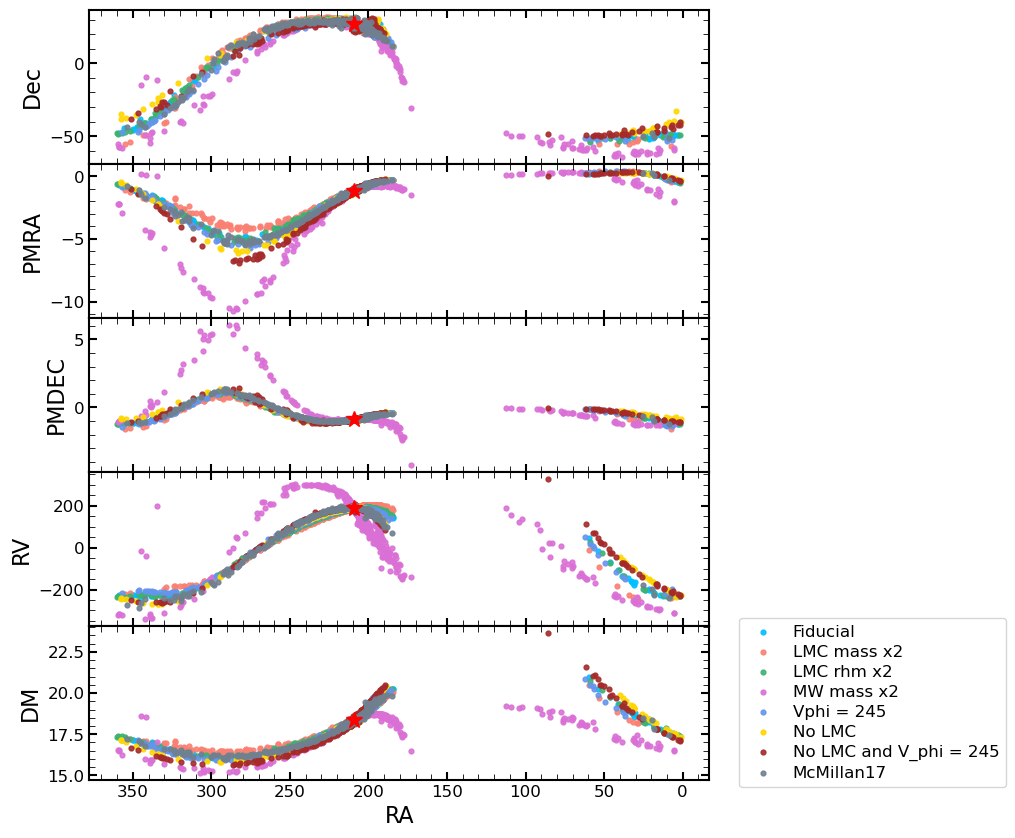

In [170]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

for i in range(len(orbit_results)):
    plot_five_params(ax, *orbit_results[i], s=12, c=_colours[i], label=_names[i], alpha=0.9)

for ax_i, label, value in zip(ax, ["Dec", "PMRA", "PMDEC", "RV", "DM"], 
                              [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)]):
    ax_i.plot(RA_BOO3, value, "*r", ms=12)
    ax_i.set_ylabel(label)
    ax_i.invert_xaxis()
ax[4].set_xlabel("RA")
    
ax[4].legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize=12)
plt.show()

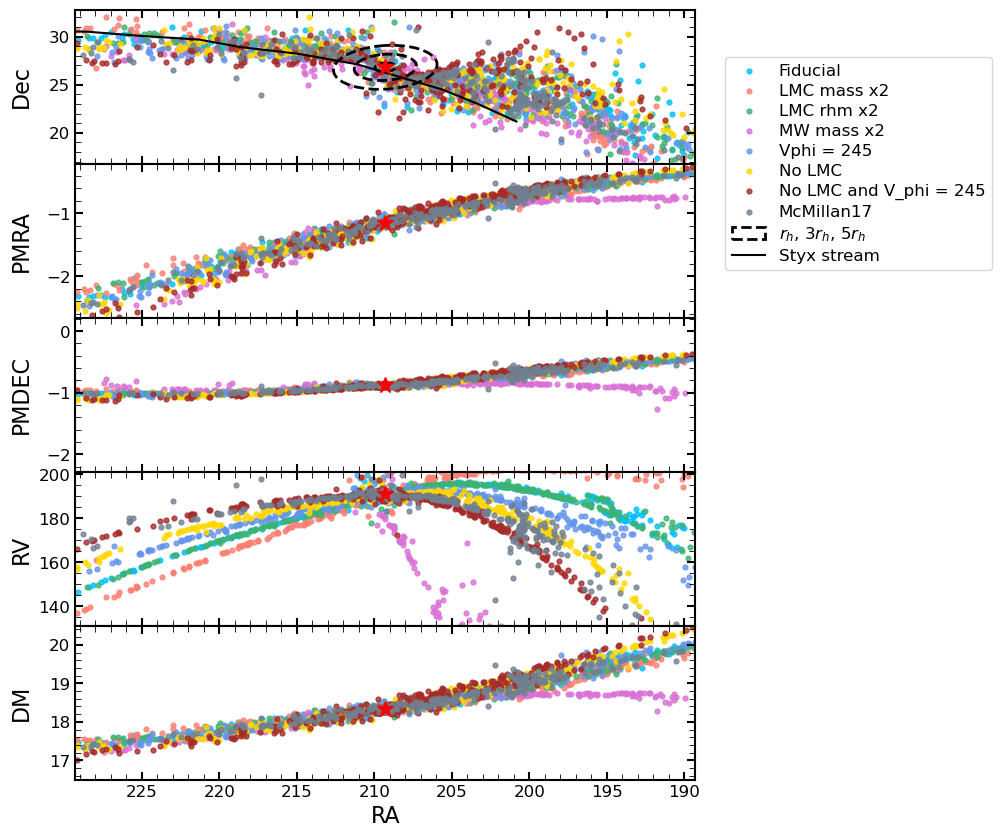

In [153]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

for i in range(len(orbit_results)):
    plot_five_params(ax, *orbit_results[i], s=12, c=_colours[i], label=_names[i], alpha=0.8)

plot_rh(ax[0])
ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
    
for ax_i, label, value, scale in zip(ax, ["Dec", "PMRA", "PMDEC", "RV", "DM"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
                                     [(DEC_BOO3-10, DEC_BOO3+6), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (VEL_BOO3-60, VEL_BOO3+10), (16.5, 20.5)]):
    ax_i.plot(RA_BOO3, value, "*r", ms=12)
    ax_i.set_ylabel(label)
    ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()
ax[4].set_xlabel("RA")

fig.align_ylabels(ax)
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0), fontsize=12)
plt.show()

In [120]:
from scipy.optimize import curve_fit

def get_model_curves(orbit_lead, orbit_trail, trim_range):
    ra = np.append(orbit_lead.ra(), orbit_trail.ra())
    dec = np.append(orbit_lead.dec(), orbit_trail.dec())
    pmra = np.append(orbit_lead.pmra(), orbit_trail.pmra())
    pmdec = np.append(orbit_lead.pmdec(), orbit_trail.pmdec())
    vlos = np.append(orbit_lead.vlos(), orbit_trail.vlos())
    dm = distance_to_dm(1000 * np.append(orbit_lead.dist(), orbit_trail.dist()))
    
    trim = (trim_range[0] < ra) & (ra < trim_range[1])
    
    # Curve fit
    def poly_2deg(x, a, b, c):
        y = a * x**2 + b * x + c
        return y

    p_opt_dec, _ = curve_fit(poly_2deg, ra[trim], dec[trim])
    p_opt_pmra, _ = curve_fit(poly_2deg, ra[trim], pmra[trim])
    p_opt_pmdec, _ = curve_fit(poly_2deg, ra[trim], pmdec[trim])
    p_opt_vlos, _ = curve_fit(poly_2deg, ra[trim], vlos[trim])
    p_opt_dm, _ = curve_fit(poly_2deg, ra[trim], dm[trim])

    x = np.arange(*trim_range, 0.1)

    # Make the model curves
    curve_pmra = np.array([x, poly_2deg(x, *p_opt_pmra)]).T
    curve_pmdec = np.array([x, poly_2deg(x, *p_opt_pmdec)]).T
    curve_rv = np.array([x, poly_2deg(x, *p_opt_vlos)]).T
    curve_dm = np.array([x, poly_2deg(x, *p_opt_dm)]).T
    curve_dec = np.array([x, poly_2deg(x, *p_opt_dec)]).T
    
    return [curve_dec, curve_pmra, curve_pmdec, curve_rv, curve_dm]

In [154]:
orbit_curves = [[] for _ in range(8)]
for i in range(len(orbit_results)):
    orbit_curves[i].extend(get_model_curves(*orbit_results[i], [RA_BOO3-20, RA_BOO3+20]))

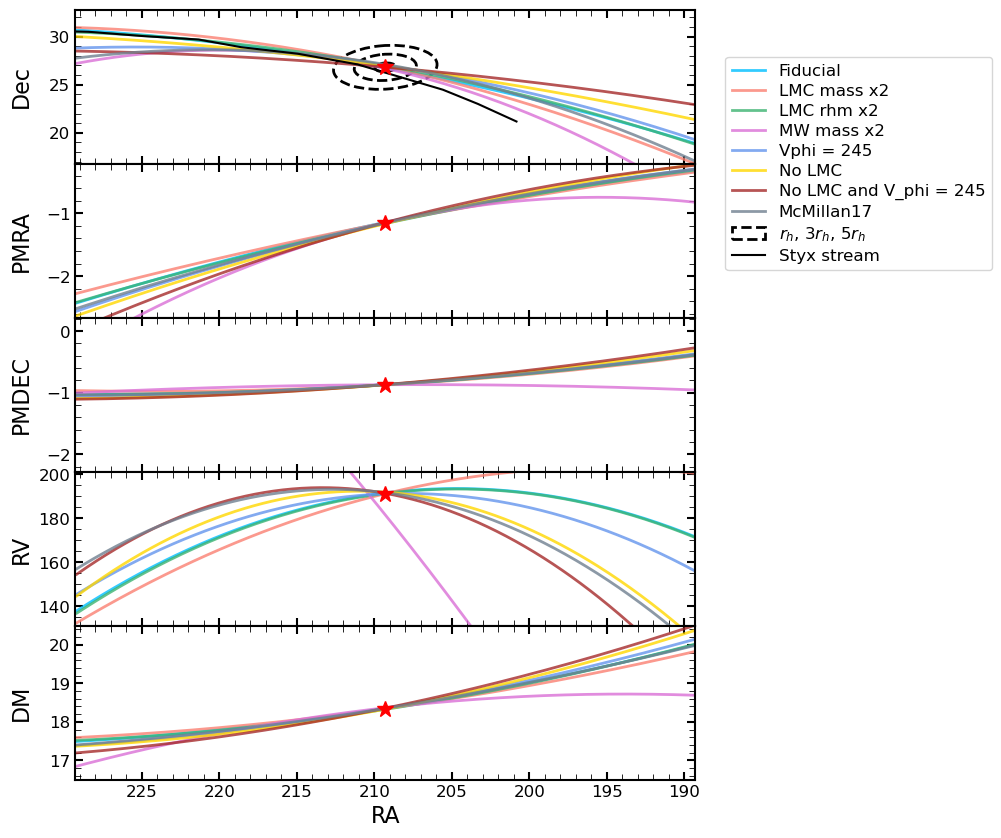

In [157]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

for curve, colour, name in zip(orbit_curves, _colours, _names):
    plot_five_curves(ax, curve, c=colour, label=name, alpha=0.8, lw=2)

plot_rh(ax[0])
ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
    
for ax_i, label, value, scale in zip(ax, ["Dec", "pmra", "PMDEC", "RV", "DM"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
                                     [(DEC_BOO3-10, DEC_BOO3+6), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (VEL_BOO3-60, VEL_BOO3+10), (16.5, 20.5)]):
    ax_i.plot(RA_BOO3, value, "*r", ms=12)
    ax_i.set_ylabel(label)
    ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()
ax[4].set_xlabel("RA")

fig.align_ylabels(ax)
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0), fontsize=12)
plt.show()

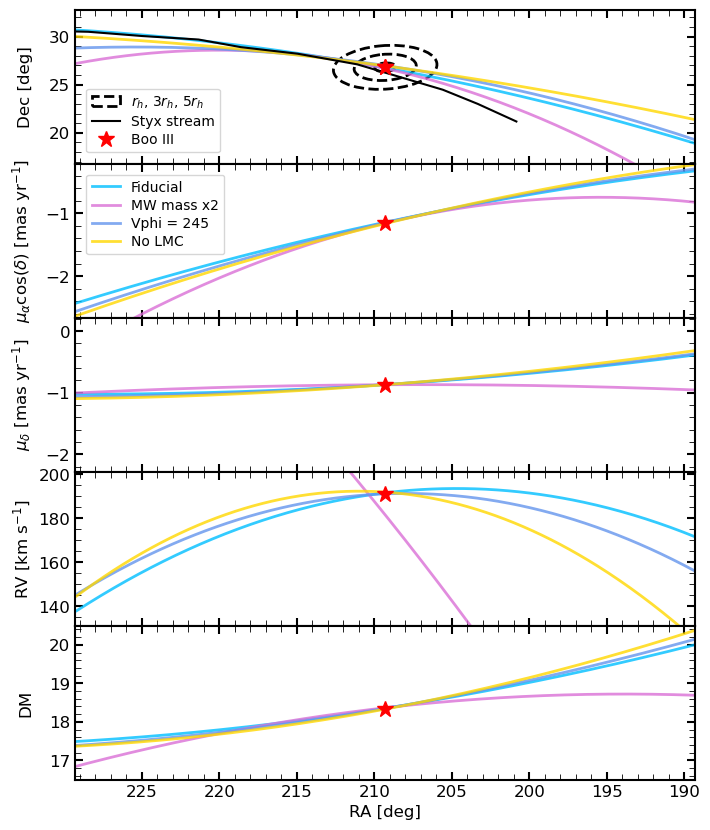

In [172]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

for i in range(len(orbit_curves)):
    if i in [0, 3, 4, 5]:
        plot_five_curves(ax, orbit_curves[i], c=_colours[i], label=_names[i], alpha=0.8, lw=2)

plot_rh(ax[0])
ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')

for ax_i, label, value, scale in zip(ax, ["Dec [deg]", pmra_label, pmdec_label, r"RV [km s$^{-1}$]", "DM"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
                                     [(DEC_BOO3-10, DEC_BOO3+6), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (VEL_BOO3-60, VEL_BOO3+10), (16.5, 20.5)]):
    ax_i.plot(RA_BOO3, value, "*r", ms=12)
    ax_i.set_ylabel(label, fontsize=12)
    ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()
ax[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III', ms=12)
ax[4].set_xlabel("RA [deg]", fontsize=12)

fig.align_ylabels(ax)
ax[0].legend(loc='lower left', fontsize=10)
ax[1].legend(loc='upper left', fontsize=10)#, bbox_to_anchor=(1.5, 0), fontsize=12)
fig.savefig('stream_comparison_selected.pdf', dpi=300, bbox_inches='tight')
plt.show()